# sprint14 ディープラーニング フレームワーク2

# 【問題1】公式チュートリアルモデルを分担して実行

##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ビジュアルアテンションを用いた画像キャプショニング

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

下記のような画像をもとに、"a surfer riding on a wave" のようなキャプションを生成することをめざします。

![Man Surfing](https://tensorflow.org/images/surf.jpg)

_[画像ソース](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); ライセンス: パブリックドメイン_

これを達成するため、アテンションベースのモデルを用います。これにより、キャプションを生成する際にモデルが画像のどの部分に焦点を当てているかを見ることができます。

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

モデルの構造は、[Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044) と類似のものです。

このノートブックには例として、一連の処理の最初から最後までが含まれています。このノートブックを実行すると、[MS-COCO](http://cocodataset.org/#home) データセットをダウンロードし、Inception V3 を使って画像のサブセットを前処理し、キャッシュします。その後、エンコーダー・デコーダーモデルを訓練し、訓練したモデルを使って新しい画像のキャプションを生成します。

この例では、比較的少量のデータ、およそ 20,000 枚の画像に対する最初の 30,000 のキャプションを使ってモデルを訓練します（データセットには 1 枚の画像あたり複数のキャプションがあるからです）。

### 画像のキャプション生成とは
画像のキャプション生成とは、画像を入力データとして与えると、画像の内容を説明する、簡単なテキストを生成することをいいます。画像タスクに多く使用されるCNN（畳み込みニューラルネットワーク）と、時系列データを取り扱うことのできるRNN（再帰型ニューラルネットワーク）の両方を使用した、複雑なモデルが使用されます。モデル構築の簡単な流れとしては、学習済みCNNで画像の特徴量を抽出し、RNNの一種であるLSTMでテキストの特徴量を抽出し、さらにデコーダーでCNNとLSTMの特徴量を結合します。そして、ソフトマックス関数で次に来る単語を予測します。



### RNNとは
時系列を扱うニューラルネットの一種。自然言語などの処理に使われる

### LSTMとは
RNNの長期の因果関係を学習するのが難しい問題点を克服したもの
忘却ゲートや記憶せると呼ばれる仕組みがある

### InceptionV3とは
Googleによって開発されたInception-v3は、ILSVRCという大規模画像データセットを使った画像識別タスク用に1,000クラスの画像分類を行うよう学習されたモデルで、非常に高い精度の画像識別を達成しています。

https://pondad.net/deep-learning/2016/12/23/keras-inceptionv3.html

### 画像キャプションの技術
https://www.slideshare.net/YoshitakaUshiku/ss-57148161

In [1]:
import tensorflow as tf

# モデルがキャプション生成中に画像のどの部分に注目しているかを見るために
# アテンションのプロットを生成
import matplotlib.pyplot as plt

# Scikit-learn には役に立つさまざまなユーティリティが含まれる
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## MS-COCO データセットのダウンロードと準備

モデルの訓練には [MS-COCO データセット](http://cocodataset.org/#home) を使用します。このデータセットには、82,000 枚以上の画像が含まれ、それぞれの画像には少なくとも 5 つの異なったキャプションがつけられています。下記のコードは自動的にデータセットをダウンロードして解凍します。

**Caution: 巨大ファイルのダウンロードあり** 訓練用のデータセットは、13GBのファイルです。

In [2]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    PATH = os.path.dirname(image_zip)+'/train2014/'
else:
    PATH = os.path.abspath('.')+'/train2014/'

## オプション： 訓練用データセットのサイズ制限

このチュートリアルの訓練をスピードアップするため、サブセットである 30,000 のキャプションと対応する画像を使ってモデルを訓練します。より多くのデータを使えばキャプションの品質が向上するでしょう。

In [3]:
# json ファイルの読み込み
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# ベクトルにキャプションと画像の名前を格納
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# captions と image_names を一緒にシャッフル
# random_state を設定
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# シャッフルしたデータセットから最初の 30,000 のキャプションを選択
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [4]:
len(train_captions), len(all_captions)

(30000, 414113)

## InceptionV3 を使った画像の前処理

つぎに、（Imagenet を使って訓練済みの）InceptionV3をつかって、画像を分類します。最後の畳み込み層から特徴量を抽出します。

最初に、つぎのようにして画像を InceptionV3 が期待するフォーマットに変換します。
* 画像を 299 ピクセル × 299 ピクセルにリサイズ
* [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) メソッドをつかって画像を InceptionV3 の訓練用画像のフォーマットに合致した −1 から 1 の範囲のピクセルを持つ形式に標準化して[画像の前処理](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) を行う

In [5]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## InceptionV3 を初期化し Imagenet で学習済みの重みをロードする

ここで、出力層が InceptionV3 アーキテクチャの最後の畳み込み層である tf.keras モデルを作成しましょう。このレイヤーの出力の shape は```8x8x2048``` です。

* 画像を 1 枚ずつネットワークに送り込み、処理結果のベクトルをディクショナリに保管します (image_name --> feature_vector)
* すべての画像をネットワークで処理したあと、ディクショナリを pickle 形式でディスクに書き出します


In [6]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## InceptionV3 から抽出した特徴量のキャッシング

それぞれの画像を InceptionV3 で前処理して出力をディスクにキャッシュします。出力を RAM にキャッシュすれば速くなりますが、画像 1 枚あたり 8 \* 8 \* 2048 個の浮動小数点数が必要で、メモリを大量に必要とします。これを書いている時点では、これは Colab のメモリ上限（現在は 12GB）を超えています。

より高度なキャッシング戦略（たとえば画像を分散保存しディスクのランダムアクセス入出力を低減するなど）を使えば性能は向上しますが、より多くのコーディングが必要となります。

このキャッシングは Colab で GPU を使った場合で約 10 分ほどかかります。プログレスバーを表示したければ次のようにします。

1. [tqdm](https://github.com/tqdm/tqdm) をインストールします:

    `!pip install -q tqdm`

2. tqdm をインポートします:

    `from tqdm import tqdm`

3. 下記の行を:

    `for img, path in image_dataset:`

    次のように変更します:

    `for img, path in tqdm(image_dataset):`


In [7]:
# 重複のない画像を取得
encode_train = sorted(set(img_name_vector))

# batch_size はシステム構成に合わせて自由に変更可能
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

## キャプションの前処理とトークン化

* まず最初に、キャプションをトークン化（たとえばスペースで区切るなど）します。これにより、データ中の重複しない単語のボキャブラリ（たとえば、"surfing"、"football" など）が得られます。
* つぎに、（メモリ節約のため）ボキャブラリのサイズを上位 5,000 語に制限します。それ以外の単語は "UNK" （不明）というトークンに置き換えます。
* 続いて、単語からインデックス、インデックスから単語への対応表を作成します。
* 最後に、すべてのシーケンスの長さを最長のものに合わせてパディングします。

In [8]:
# データセット中の一番長いキャプションの長さを検出
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
# ボキャブラリ中のトップ 5000 語を選択
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [10]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [11]:
# トークン化したベクトルを生成
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
# キャプションの最大長に各ベクトルをパディング
# max_length を指定しない場合、pad_sequences は自動的に計算
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [13]:
# アテンションの重みを格納するために使われる max_length を計算
max_length = calc_max_length(train_seqs)

## データを訓練用とテスト用に分割

In [14]:
# 訓練用セットと検証用セットを 80-20 に分割して生成
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [15]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## 訓練用の tf.data データセットの作成

画像とキャプションが用意できました。つぎは、モデルの訓練に使用する tf.data データセットを作成しましょう。

In [16]:
# これらのパラメータはシステム構成に合わせて自由に変更してください

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# InceptionV3 から抽出したベクトルの shape は (64, 2048)
# つぎの 2 つのパラメータはこのベクトルの shape を表す
features_shape = 2048
attention_features_shape = 64

In [17]:
# numpy ファイルをロード
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# numpy ファイルを並列に読み込むために map を使用
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# シャッフルとバッチ化
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## モデル

興味深い事実：下記のデコーダは[Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb) の例のデコーダとまったく同一です。

このモデルのアーキテクチャは、[Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) の論文にインスパイアされたものです。

* この例では、InceptionV3 の下層の畳込みレイヤーから特徴量を取り出します。得られるベクトルの shape は (8, 8, 2048) です。
* このベクトルを (64, 2048) に変形します。
* このベクトルは（1層の全結合層からなる）CNN エンコーダに渡されます。
* RNN（ここではGRU）が画像を介して次の単語を予測します。

In [19]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # score を self.V に適用するので、最後の軸は 1 となる
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # 合計をとったあとの　context_vector の shpae == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
class CNN_Encoder(tf.keras.Model):
    # すでに特徴量を抽出して pickle 形式でダンプしてあるので
    # このエンコーダはそれらの特徴量を全結合層に渡して処理する
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [21]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # アテンションを別のモデルとして定義
    context_vector, attention_weights = self.attention(features, hidden)

    # embedding 層を通過したあとの x の shape == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 結合したベクトルを GRU に渡す
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [22]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## チェックポイント

In [24]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## 訓練

* それぞれの `.npy` ファイルに保存されている特徴量を取り出し、エンコーダに渡す
* エンコーダの出力と（0 で初期化された）隠れ状態と、デコーダの入力（開始トークン）をデコーダに渡す
* デコーダは予測値とデコーダの隠れ状態を返す
* デコーダの隠れ状態はモデルに戻され、予測値をつかって損失を計算する
* デコーダの次の入力を決めるために teacher forcing を用いる
* Teacher forcing は、デコーダの次の入力として正解の単語を渡す手法である
* 最後のステップは、勾配を計算してそれをオプティマイザに適用し誤差逆伝播を行うことである

In [26]:
# 訓練用のセルを複数回実行すると loss_plot 配列がリセットされてしまうので
# 独立したセルとして追加
loss_plot = []

In [27]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # バッチごとに隠れ状態を初期化
  # 画像のキャプションはその前後の画像と無関係なため
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # 特徴量をデコーダに渡す
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # teacher forcing を使用
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [29]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # 後ほどグラフ化するためにエポックごとに損失を保存
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8092
Epoch 1 Batch 100 Loss 0.7607
Epoch 1 Batch 200 Loss 0.8162
Epoch 1 Batch 300 Loss 0.8222
Epoch 1 Loss 0.784309
Time taken for 1 epoch 759.1188910007477 sec

Epoch 2 Batch 0 Loss 0.7327
Epoch 2 Batch 100 Loss 0.7095
Epoch 2 Batch 200 Loss 0.6826
Epoch 2 Batch 300 Loss 0.7400
Epoch 2 Loss 0.724045
Time taken for 1 epoch 727.4408810138702 sec

Epoch 3 Batch 0 Loss 0.6336
Epoch 3 Batch 100 Loss 0.7141
Epoch 3 Batch 200 Loss 0.6598
Epoch 3 Batch 300 Loss 0.7071
Epoch 3 Loss 0.682423
Time taken for 1 epoch 725.6050622463226 sec

Epoch 4 Batch 0 Loss 0.6411
Epoch 4 Batch 100 Loss 0.6526
Epoch 4 Batch 200 Loss 0.6253
Epoch 4 Batch 300 Loss 0.6618
Epoch 4 Loss 0.647366
Time taken for 1 epoch 727.1803851127625 sec

Epoch 5 Batch 0 Loss 0.6307
Epoch 5 Batch 100 Loss 0.6131
Epoch 5 Batch 200 Loss 0.6085
Epoch 5 Batch 300 Loss 0.5710
Epoch 5 Loss 0.613533
Time taken for 1 epoch 737.2890532016754 sec

Epoch 6 Batch 0 Loss 0.6007
Epoch 6 Batch 100 Loss 0.5830
Epoch 6 Batc

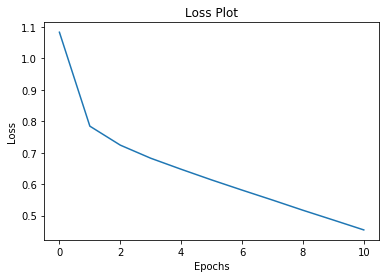

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## キャプション！

* 評価関数は訓練ループとおなじだが、teacher forcing は使わない。タイムステップごとのデコーダへの入力は、隠れ状態とエンコーダの入力に加えて、一つ前の予測値である。
* モデルが終了トークンを予測したら、予測を終了する。
* それぞれのタイムステップごとに、アテンションの重みを保存する。

In [31]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [32]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a couple of pieces of food on some white plates <end>
Prediction Caption: a rice sandwich on a plate containing a plate <end>


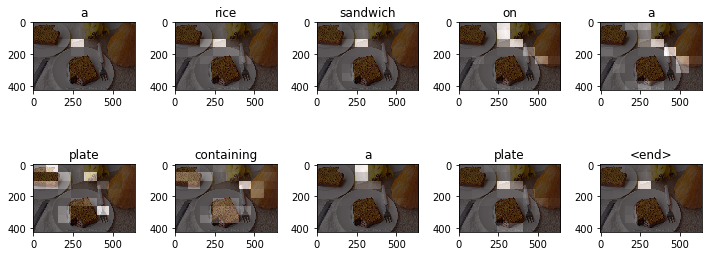

In [33]:
# 検証用セットのキャプション
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## あなた独自の画像でためそう

お楽しみのために、訓練したばかりのモデルであなたの独自の画像を使うためのメソッドを下記に示します。比較的少量のデータで訓練していること、そして、あなたの画像は訓練データとは異なるであろうことを、心に留めておいてください（変な結果が出てくることを覚悟しておいてください）。

65536/64400 [==============================] - 0s 0us/step
Prediction Caption: a man ridding a wave in the water <end>


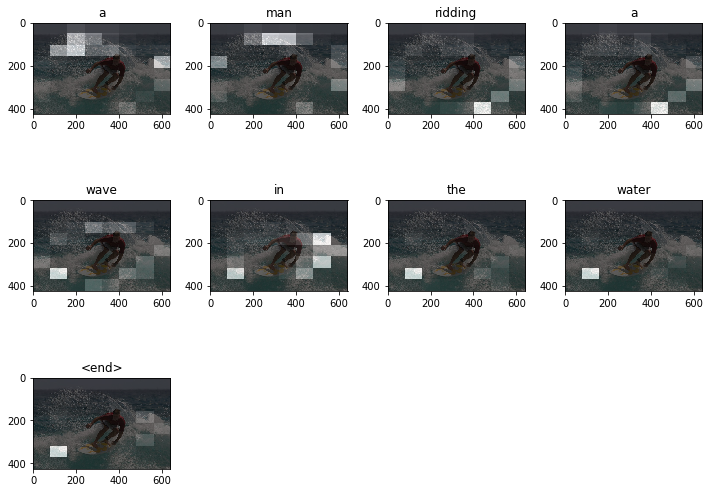

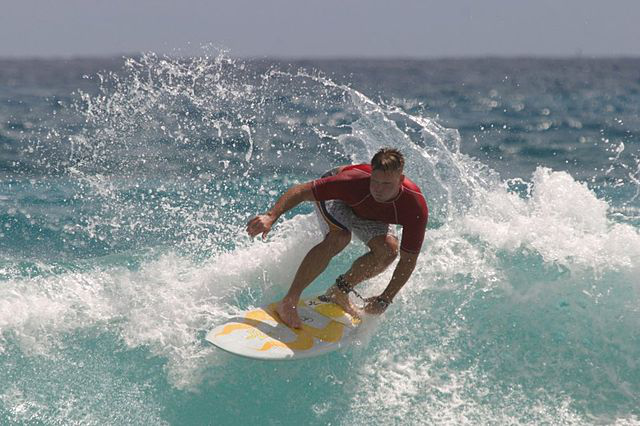

In [34]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# 画像を開く
Image.open(image_path)

授業では、自分の写真を表示させましたが、Gitにアップするため削除しました。

# 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
#!pip install --user tensorflow==2.0.0

In [5]:
#!pip install --user keras==2.2.4

In [2]:
tf.__version__

'2.0.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [6]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [28]:
X_train.shape

(64, 4)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [21]:
from tensorflow.keras import backend as K

In [34]:
K.clear_session()

In [35]:
# ロジスティック回帰
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, input_shape=(4,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss="binary_crossentropy",
             optimizer=tf.optimizers.Adam(learning_rate=0.01),
             metrics=["accuracy"])

In [37]:
history = model.fit(X_train, y_train,
                   batch_size=1,
                   epochs=100,
                   verbose=1,
                   validation_data=(X_val, y_val))

Train on 64 samples, validate on 16 samples
Epoch 1/100
64/64 [==============================] - 0s 5ms/sample - loss: 1.2555 - accuracy: 0.3125 - val_loss: 1.0506 - val_accuracy: 0.1875
Epoch 2/100
64/64 [==============================] - 0s 1ms/sample - loss: 0.9909 - accuracy: 0.2188 - val_loss: 1.0505 - val_accuracy: 0.1875
Epoch 3/100
64/64 [==============================] - 0s 1ms/sample - loss: 0.9375 - accuracy: 0.2969 - val_loss: 0.9937 - val_accuracy: 0.1875
Epoch 4/100
64/64 [==============================] - 0s 1ms/sample - loss: 0.9078 - accuracy: 0.3594 - val_loss: 0.9287 - val_accuracy: 0.0625
Epoch 5/100
64/64 [==============================] - 0s 1ms/sample - loss: 0.9053 - accuracy: 0.2344 - val_loss: 0.9318 - val_accuracy: 0.1875
Epoch 6/100
64/64 [==============================] - 0s 1ms/sample - loss: 0.8678 - accuracy: 0.4531 - val_loss: 0.8803 - val_accuracy: 0.0625
Epoch 7/100
64/64 [==============================] - 0s 1ms/sample - loss: 0.8673 - accuracy: 0.26

In [39]:
score = model.evaluate(X_val, y_val, verbose=0)
print('val loss:', score[0])
print('val accuracy:', score[1])

val loss: 0.17635712027549744
val accuracy: 1.0


# 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [40]:
from sklearn.preprocessing import OneHotEncoder
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

In [41]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])

In [44]:
y_one_hot = y_one_hot.astype(np.int)

In [46]:
y_one_hot.shape

(150, 3)

In [47]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [56]:
K.clear_session()

In [57]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss="categorical_crossentropy",
             optimizer=tf.optimizers.Adam(learning_rate=0.01),
             metrics=["accuracy"])
history = model.fit(X_train, y_train,
                   batch_size=1,
                   epochs=100,
                   verbose=0,
                   validation_data=(X_val, y_val))

In [61]:
score = model.evaluate(X_val, y_val, verbose=0)
print('val loss:', score[0])
print('val accuracy:', score[1])

val loss: 0.19840414822101593
val accuracy: 0.875


# 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [63]:
# データセットの読み込み
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)

In [64]:
# 対数変換
y = np.log(y)
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

In [65]:
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [67]:
X_train.shape

(934, 2)

In [66]:
K.clear_session()

In [68]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(loss="mean_squared_error",
             optimizer=tf.optimizers.Adam(learning_rate=0.01),
             metrics=["mean_squared_error"])
history = model.fit(X_train, y_train,
                   batch_size=10,
                   epochs=100,
                   verbose=0,
                   validation_data=(X_val, y_val))

In [73]:
score = model.evaluate(X_val, y_val, verbose=0)
print('val loss:', score[0])

val loss: 132.44444450965295


# 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [74]:
mnist = keras.datasets.mnist

In [75]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [77]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y_train[:, np.newaxis])

In [78]:
y_one_hot = y_one_hot.astype(np.int)

In [80]:
y_one_hot.shape

(60000, 10)

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_one_hot, test_size=0.2, random_state=0)

In [88]:
X_train = X_train.reshape(48000, 28, 28, 1)
X_val = X_val.reshape(12000, 28, 28, 1)

In [89]:
X_val.shape

(12000, 28, 28, 1)

In [105]:
K.clear_session()

In [106]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu, padding="same", input_shape=[28, 28, 1]))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                802880    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 804,170
Trainable params: 804,170
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.compile(loss="categorical_crossentropy",
             optimizer=tf.optimizers.Adam(learning_rate=0.01),
             metrics=["accuracy"])
history = model.fit(X_train[0:1000], y_train[0:1000],
                   batch_size=10,
                   epochs=5,
                   verbose=0,
                   validation_data=(X_val[0:100], y_val[0:100]))

In [108]:
score = model.evaluate(X_val, y_val, verbose=0)
print('val loss:', score[0])
print('val accuracy:', score[1])

val loss: 1.1065848108530045
val accuracy: 0.73733336


全てのデータを使用して学習をさせていましたが、色々試していたところ処理に時間がかかりすぎるのでデータを小さくしました。